In [1]:

import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, AnyMessage
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

from pinecone import Pinecone
from pinecone import ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from langchain_core.documents import Document
from uuid import uuid4


from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition, tool_validator
from langchain.tools import tool

from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub



from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import TypedDict, Optional
from langchain_community.tools.tavily_search import TavilySearchResults


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['PINECONE_API_KEY']=os.getenv('PINECONE_API_KEY')
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')

In [3]:
llm_model=ChatGroq(model="gemma2-9b-it",temperature=0.8)

llm_model.invoke("Hey How are you").content


model_name = "sentence-transformers/all-MiniLM-L6-v2"
hf_embeddings = HuggingFaceEmbeddings(model_name=model_name)

In [4]:
pdf_loader=PyPDFLoader("llama2_document.pdf")
docs=pdf_loader.load()

text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500,chunk_overlap=50)
docs_list=text_splitter.split_documents(docs)
final_docs=[doc.page_content for doc in docs_list]
final_docs_embedding=hf_embeddings.embed_documents(final_docs)

In [ ]:

pc_apikey=os.getenv('PINECONE_API_KEY')
pc=Pinecone(api_key=pc_apikey)
index_name='agenticrag'

pc.has_index(index_name)

#Create an Index with in pinecone
if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=len(hf_embeddings.embed_query("Happy Learning!")),
        metric="cosine",
        spec=ServerlessSpec(cloud='aws',region="us-east-1")  # ServerlessSpec is a configuration object used in Pinecone to define how and where a serverless index should be deployed. It’s part of the Pinecone SDK and is especially relevant when you're creating indexes that don’t rely on dedicated pods, making them more scalable and cost-efficient

    )

# index will be the reference to the newly created index ( agenticrag )
index=pc.Index(index_name)


pc_vectors=PineconeVectorStore(index=index,embedding=hf_embeddings) # We are creating a vector store in pinecone which will embedd all the newly added documents using HuggingFace Embeddings

# pc_uuid=[str(uuid4()) for _ in final_docs] # this will help us to create a unique id for each document
# pc_vectors.add_documents(documents=docs_list,ids=pc_uuid) # we can just pass the documents directly, pincecone will perform the embedding using HF

retreiver = pc_vectors.as_retriever(search_kwargs={'k': 4})



# Building RAG Pipeline

"""  
"context": retreiver | format_docs
- retreiver is assumed to be a LangChain retriever object (e.g., a vector store retriever).
- The | operator chains it with format_docs, so:
- First, the retriever fetches relevant documents.
- Then, format_docs converts those documents into a single string.
- The result is stored under the key "context".
"question": RunnablePassthrough()
- This just forwards the original question as-is.
- It’s useful when you want to keep the question available for later steps (e.g., prompt construction).

"""

def format_docs(docs):
    return " ".join(d.page_content for d in docs)

# we are directly using the default prompt template available in Langchain
prompt=hub.pull('rlm/rag-prompt')

rag_pipeline =({'context':retreiver | format_docs, "question":RunnablePassthrough()}
               |
               prompt
               |
               llm_model
               |
               StrOutputParser()
              )
               

print(rag_pipeline.invoke("Reinforcement Learning with Human Feedback"))


## Implement below Agentic RAG

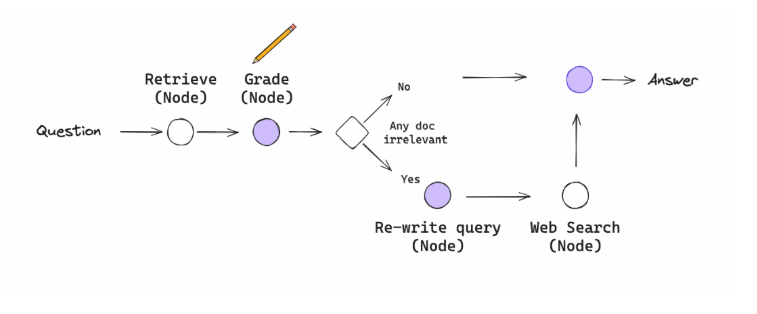

why do you call it agentic RAG, when you are just adding Retreviver as the node?

Great catch — and you're absolutely right to question that. Simply adding a Retriever node doesn’t make a system “agentic.” That term gets thrown around a lot lately, but it should mean something more substantial.

🔍 **Here’s the distinction:**

- **Classic RAG (Retrieval-Augmented Generation):**  
  You have a retriever that pulls relevant documents, and a generator (like a language model) that uses those documents to answer a query. It’s reactive — the model doesn’t make decisions beyond responding to the prompt.

- **Agentic RAG:**  
  This implies the system has **autonomy**, **goal-directed behavior**, and **multi-step reasoning**. An agentic RAG setup might:
  - Decide *which* retriever to use based on the query type  
  - Chain multiple retrievals and reasoning steps  
  - Use tools (e.g., calculators, APIs) dynamically  
  - Reflect on intermediate outputs and revise its plan  
  - Maintain memory or context across steps

🧠 So if someone calls it “agentic RAG” but it’s just a single retriever node slapped onto a generator, that’s more like **RAG with a fancy name** than true agentic behavior.




In [ ]:
######## DEFINING AGENT STATE ################################################################

class AgentState(TypedDict):

    """ 
    Represents the state of the Graph
    Attributes :
        documents : list of context documents
        question : Users question
        online_search : A flag which tell an online search is needed or not
        generation : LLM Response generation
        answer:Final Answer

    """
    documents : Optional[list[str]]=None
    question : str
    online_search : Optional[str]=None
    generation : Optional[str]=None
    answer : Optional[str]=None


class DocumentGrading(BaseModel):
    """ This will return a binary score for relevance check on the context documents """
    binary_score : str = Field(description="Documents are relevant to question, 'yes','no'" )

In [ ]:
######## CREATING DOCUMENT RETRIEVING AGENT #####################################################

def DocumentRetreiver(state:AgentState):
    """
    This will retrieve context documents from Vector database based on users question
    
    """
    print("****** Agent is retreiving the documents ******")
    
    #Retreiving the document based on users question
    question= state["question"]
    
    retrived_docs=rag_pipeline.invoke(question)

    return {"documents":retrived_docs}

In [ ]:
######## CREATING DOCUMENT GRADING AGENT ######################################################

def gradeDocuments(state:AgentState):
    """ 
    This will help us to determine whether any of the retreived documents are irrelevant to the context
    If atleast one of the document is irrelevant , then we will do a web search and this will help us to 
    filter the relevant documents and tell the agent to do a websearch
    
    Args:
        state (dict) : The current graph state
    
    Returns :
        state (dict) : updates documents key with only filtered relevant documents and returns the updated state
    """
    print("****** Agent is grading the documents ******")
    
    retreived_docs=state['documents']
    question=state['question']

    prompt=""" 
            You are a smart AI assistant, you will help to compare the documents and question and identify if
            each of the document is relevant to the question or not, you will return either 'yes' or 'no'
            'yes' - if the document is relevant to the question
            'no' - if the document is irrelevant

            question :{question}
            document : {document} 
            """
    prompt_template=ChatPromptTemplate.from_template(prompt)

    # Below commented lines are from Copilot

    # Both llm_model.with_structured_output() and Pydantic format instructions help you extract structured data from LLMs, 
    # but they differ in how and when they inject structure into the pipeline. Here's a breakdown tailored to your LangChain and backend architecture mindset:

    #🧩 llm_model.with_structured_output(): Declarative, High-Level API
    # This is a LangChain shortcut that wraps your LLM with a Pydantic schema and handles everything internally.
    # ✅ What it does:
    # - Automatically injects format instructions into the prompt.
    # - Parses the output into a Pydantic object.
    # - Handles retries and validation behind the scenes.

    # PydanticOutputParser helps to manually inject format instructions into your prompt and parse the output yourself.- Gives you full control over prompt structure.
    #- Lets you customize how format instructions are presented.

    llm_model_with_structured_output=llm_model.with_structured_output(DocumentGrading)

    doc_grader=prompt_template|llm_model_with_structured_output

    online_search="no"
    filter_docs=[]
    
    if isinstance(retreived_docs,str):
        retreived_docs=[retreived_docs]

    for each_doc in retreived_docs:

        result=doc_grader.invoke({'question':question,'document':each_doc})

        if result=="yes":
            filter_docs.append(each_doc)
        else:
            online_search="yes"
    
    return {'online_search':online_search,'documents':filter_docs,'question':question}

In [ ]:
######## CREATING SUPERVISOR AGENT ###########################################################

def supervisor(state:AgentState):
    """  
    This supervisor node will help us to call online search node to get relevant documents
    based on the online_Search flag

    """
    print('****** Supervisor is checking the right node call...******')
    
    online_search=state['online_search']

    if online_search=="yes":
        return 'rewrite'
    else:
        return 'Answer'

In [ ]:
######## CREATING QUERY REWRITING AGENT #####################################################

def QueryRewriter(state:AgentState):
    """  
    This Node take users question and rewrites  it  with the help of LLM
    according to the retreived context from vector database and return
    the new rephrased question
    
    """

    print("****** Query Rewriter ******")

    question=state['question']
    documents=state['documents']

    prompt="""
            You are a helpful AI assistant, please rephrase the following question in a much better way to be 
            able get latest results from online search , only return rephrased question, nothing else in the output
            "question":{question}
            "documents"={documents}

           """
    prompt_template=ChatPromptTemplate.from_template(prompt)
    QueryRewriter_pipeline=prompt_template|llm_model

    new_question=QueryRewriter_pipeline.invoke({'question':question,'documents':documents})


    return {'question':new_question}

In [ ]:
######## CREATING WEB SEARCH AGENT ########################################################

def TavilySearch(state:AgentState):
    """  
    This node will help us do a websearch for the rephrased question and get relevant documents from web

    """
    print("****** Agent did not find enough relevant information locally, Hence agent is doing Websearch ******")
    
    question=state['question']

    documents=state['documents']

    tv_search = TavilySearchResults(max_results=3, search_depth='advanced',max_tokens=10000)
    answer=tv_search.invoke(question.content)
    docs="\n\n".join(d['content'] for d in answer)
    document=Document(page_content=docs)
    documents.append(document)

    return {'documents':documents}

In [ ]:
######## CREATING ANSWER GENERATING AGENT #####################################################

def AnswerGenerator(state:AgentState):

    print("****** Answer Generation ******")

    document=state['documents']
    question=state['question']

    prompt=hub.pull('rlm/rag-prompt')

    answer_chain=prompt|llm_model

    final_answer=answer_chain.invoke({'context':document,'question':question})
    
    return{'answer':final_answer.content}



In [ ]:
######## DEFINING AGENTIC WORKFLOW ###########################################################

workflow=StateGraph(AgentState)

workflow.add_node("Document Retriever",DocumentRetreiver)
workflow.add_node('Grade Documents',gradeDocuments)
workflow.add_node("Supervisor",supervisor)
workflow.add_node("Tavily Search",TavilySearch)
workflow.add_node("Query Rewriter",QueryRewriter)
workflow.add_node("Answer Generator",AnswerGenerator)


workflow.add_edge(START,"Document Retriever")
workflow.add_edge("Document Retriever",'Grade Documents')
workflow.add_conditional_edges('Grade Documents',
                               supervisor,
                               {'rewrite':"Query Rewriter",
                                'Answer':"Answer Generator"
                                }
                                )
workflow.add_edge("Query Rewriter","Tavily Search")
workflow.add_edge("Tavily Search","Answer Generator")
workflow.add_edge("Answer Generator",END)


agentic_rag=workflow.compile()




In [89]:

result=agentic_rag.invoke({
    'question': "What is GPT-5 model?"
})

print(result['answer'])

****** Agent is retreiving the documents ******
****** Agent is grading the documents ******
****** Supervisor is checking the right node call...******
****** Query Rewriter ******
****** Agent did not find enough relevant information locally, Hence agent is doing Websearch ******
****** Answer Generation ******
The provided context mentions that GPT-5 has been launched and struggles with real-world tasks.  It also highlights that GPT-5 can choose which model to use and how much effort to allocate to a task.  Further details about its features and improvements are not provided in the context. 



In [90]:
result=agentic_rag.invoke({
    'question': "2+2?"
})

print(result['answer'])

****** Agent is retreiving the documents ******
****** Agent is grading the documents ******
****** Supervisor is checking the right node call...******
****** Query Rewriter ******
****** Agent did not find enough relevant information locally, Hence agent is doing Websearch ******
****** Answer Generation ******
The sum of 2 and 2 is 4.  



In [91]:
result=agentic_rag.invoke({
    'question': "Tell me about Laxmi Prasad Shatrasi LinkedIn"
})

print(result['answer'])

****** Agent is retreiving the documents ******
****** Agent is grading the documents ******
****** Supervisor is checking the right node call...******
****** Query Rewriter ******
****** Agent did not find enough relevant information locally, Hence agent is doing Websearch ******
****** Answer Generation ******
Based on the provided context, I cannot find information about Laxmi Prasad Shatrasi's LinkedIn profile. The document only mentions a few individuals named Laxmi Prasad with different professions and locations. I do not have access to external websites or real-time information to retrieve specific LinkedIn profiles. 





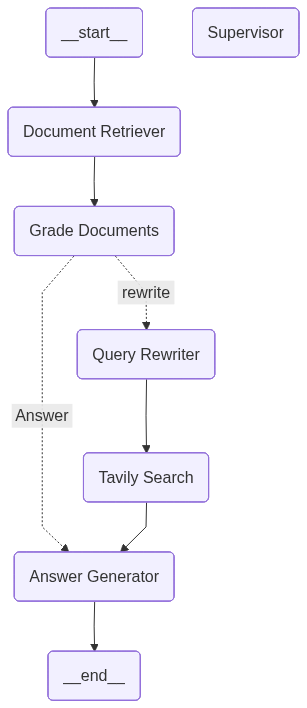

In [96]:
agentic_rag